## ResNet Regression for Interest Rate Prediciton

***Please Note:*** *Import data_contruction and cleaned_full_data from correct paths*

In [2]:
from tensorflow.keras import layers,models
from tensorflow.keras import callbacks
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
import data_construction as dc
from sklearn.decomposition import PCA

Using the values columns identified by Lasso

In [146]:
clean_data = 'cleaned_full_data.csv'

# import data
df = pd.read_csv(clean_data, index_col=0)

# interpolate and join
test = dc.det_interp(df.iloc[:,1])
econ_interp = df.iloc[:,:-1].apply(dc.det_interp, axis=0)
df = pd.concat([econ_interp, df.iloc[:,-1]], axis=1, join="outer")

del df['GS10']

# perform time lags
df['SVENY10_1'] = df['SVENY10'].shift(-1)
df['SVENY10_60'] = df['SVENY10'].shift(-60)
df_lag_1 = df.iloc[:,:-1].dropna().drop(['SVENY10'], axis=1)
df_lag_60 = df.drop(['SVENY10_1', 
    'SVENY10'], axis=1).dropna()

df_actual_lag_1 = df[['GS5', 'AAA', 'USTRADE', 'T5YFFM', 'EXUSUKx', 'SVENY10_1']].dropna()
df_actual_lag_60 = df[['GS5', 'AAA', 'USTRADE', 'T5YFFM', 'EXUSUKx', 'SVENY10_60']].dropna()
display(df_actual_lag_60)

,GS5,AAA,USTRADE,T5YFFM,EXUSUKx,SVENY10_60
1992-02-03,6.580000,8.290000,12824.200000,2.520000,1.777800,7.8521
1992-02-04,6.599474,8.293158,12824.210526,2.543684,1.774958,7.8484
1992-02-05,6.618947,8.296316,12824.221053,2.567368,1.772116,7.8211
1992-02-06,6.638421,8.299474,12824.231579,2.591053,1.769274,7.8425
1992-02-07,6.657895,8.302632,12824.242105,2.614737,1.766432,7.8218
...,...,...,...,...,...,...
2019-11-26,1.673333,3.018333,15611.916667,0.123333,1.307150,1.3437
2019-11-27,1.675556,3.015556,15614.311111,0.125556,1.308400,1.3440
2019-11-29,1.677778,3.012778,15616.705556,0.127778,1.309650,1.3148
2019-12-02,1.680000,3.010000,15619.100000,0.130000,1.310900,1.1490


Generating a standardized the dataset with test train split

In [162]:
def get_dataset(data, train=True, predict_days=60):
  dataset = np.array(data)

  x = dataset[:,:-1]
  y = dataset[:, -1]
  y = y.reshape(-1,1)

  scaler_x = StandardScaler()
  scaler_y = StandardScaler()
  scaler_x.fit(x)
  xscale = scaler_x.transform(x)
  # scaler_y.fit(y)
  # yscale = scaler_y.transform(y)

  yscale = y

  # X_train, X_test, y_train, y_test = train_test_split(xscale, yscale,test_size=0.05)
  if train:
    return train_test_split(xscale, yscale,test_size=0.01)
  else:
    return xscale[-predict_days:, :], yscale[-predict_days:,]

### Residual Network for Regression

*The model is motivated from the [paper](https://https://www.mdpi.com/1099-4300/22/2/193)*

In [168]:
def identity_block(input_tensor,units):
  x = layers.Dense(units)(input_tensor)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Dense(units)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Dense(units)(x)
  x = layers.BatchNormalization()(x)

  x = layers.add([x, input_tensor])
  x = layers.Activation('relu')(x)

  return x

def dens_block(input_tensor,units):
  x = layers.Dense(units)(input_tensor)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Dense(units)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Dense(units)(x)
  x = layers.BatchNormalization()(x)

  shortcut = layers.Dense(units)(input_tensor)
  shortcut = layers.BatchNormalization()(shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)
  return x


def ResNet50Regression(inputshape):
  Res_input = layers.Input(shape=inputshape)

  width = 16

  x = dens_block(Res_input,width)
  x = identity_block(x,width)
  x = identity_block(x,width)

  x = dens_block(x,width)
  x = identity_block(x,width)
  x = identity_block(x,width)

  x = dens_block(x,width)
  x = identity_block(x,width)
  x = identity_block(x,width)

  x = layers.BatchNormalization()(x)
  x = layers.Dense(1, activation='linear')(x)
  model = models.Model(inputs=Res_input, outputs=x)

  return model

Training the model and predicting the values

In [153]:
def train_predict(data, epochs=80, verbose=0):
  X_train, X_test, y_train, y_test = get_dataset(data=data)

  model = ResNet50Regression((5,))
  model.compile(loss='mse', optimizer='adam', metrics=['mse'])

  # Takes around 2 minutes to train on CPU
  history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, validation_split=0.2)


  yhat = model.predict(X_test)
  print('The test loss:', mean_squared_error(yhat,y_test))

  # "Loss"
  plt.figure(1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')

  plt.figure(2)
  plt.plot(y_test[-50:]) 
  plt.plot(yhat[-50:])
  plt.title('Result for ResNet Regression')
  plt.ylabel('SVENY10')
  plt.xlabel('Data points')
  plt.legend(['Real value', 'Predicted Value'], loc='upper right')


  temp_x, temp_y = get_dataset(data, train=False, predict_days=180)
  temp_yhat = model.predict(temp_x)
  temp_mse = round(mean_squared_error(temp_y, temp_yhat), 5)
  plt.figure(3)
  plt.plot(temp_y) 
  plt.plot(temp_yhat)
  plt.title('ResNet Result without shuffling (MSE=' + str(temp_mse) + ')')
  plt.ylabel('SVENY10')
  plt.xlabel('No. of Days')
  plt.legend(['Real value', 'Predicted Value'], loc='upper right')

  temp_x, temp_y = get_dataset(data, train=False, predict_days=60)
  temp_yhat = model.predict(temp_x)
  temp_mse = round(mean_squared_error(temp_y, temp_yhat), 5)
  plt.figure(4)
  plt.plot(temp_y) 
  plt.plot(temp_yhat)
  plt.title('ResNet Result without shuffling (MSE=' + str(temp_mse) + ')')
  plt.ylabel('SVENY10')
  plt.xlabel('No. of Days')
  plt.legend(['Real value', 'Predicted Value'], loc='upper right')

  plt.show()

Predicting with values lag=1


The test loss: 0.01849293862583784


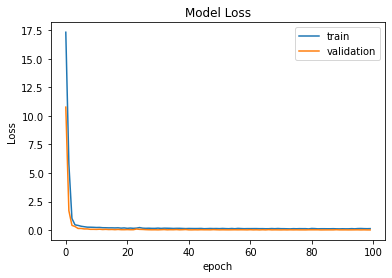

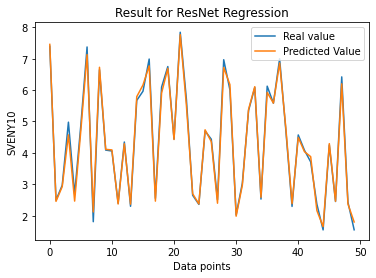

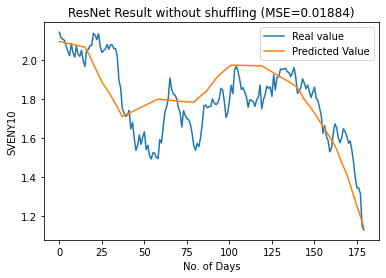

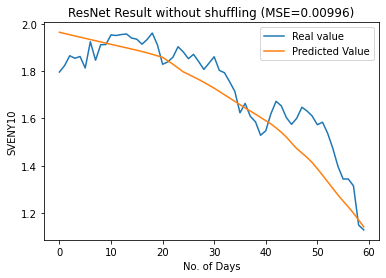

In [173]:
train_predict(df_actual_lag_1, epochs=100, verbose=0)

Predicting with lag=60

The test loss: 0.04022654359733611


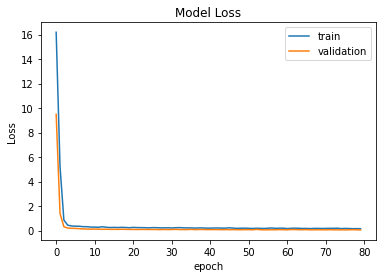

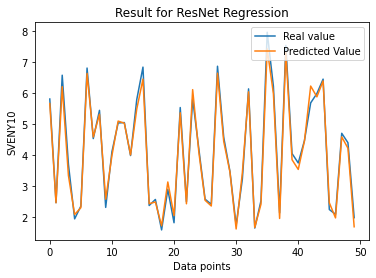

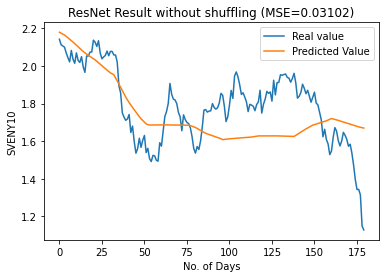

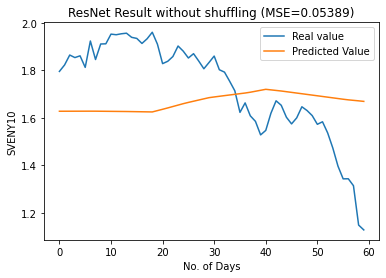

In [177]:
train_predict(df_actual_lag_60, epochs=80)